In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score, accuracy_score,confusion_matrix, f1_score, precision_score, recall_score
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
from models import networks

/home/kuhaku/mambaforge-pypy3/envs/3m-ser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from configs.base import Config
checkpoint_path = "/home/kuhaku/Code/EmotionClassification/code/3m-ser-private/scripts/checkpoints/3M-SER_losses/cls_roberta_wav2vec2_base/20231113-221659"
cfg_path = os.path.join(checkpoint_path,"cfg.log")
ckpt_path = os.path.join(checkpoint_path,"weights/best_acc/checkpoint_0_0.pt")

cfg = Config()

cfg.load(cfg_path)
# Set dataset path
cfg.data_root="/home/kuhaku/Code/EmotionClassification/code/3m-ser-private/notebooks/data/IEMOCAP/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = getattr(networks, cfg.model_type)(cfg)
network.to(device)

# Build dataset
train_ds, test_ds = build_train_test_dataset(cfg)
weight = torch.load(ckpt_path, map_location=torch.device(device))
if cfg.save_all_states:
    weight = weight['state_dict_network']
else:
    weight = weight.state_dict()

network.load_state_dict(weight)
network.eval()
network.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MMSERA_v2(
  (text_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [3]:
from torch import nn
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
fuse_audio_sim = []
fuse_text_sim = []
audio_text_sim = []

for every_test_list in tqdm(train_ds):
    input_ids, audio, label = every_test_list
    input_ids = input_ids.to(device)
    audio = audio.to(device)
    label = label.to(device)
    with torch.no_grad():
        out, fusion_embeddings, text_embeddings, audio_embeddings = network(input_ids,audio)
    fuse_audio_sim.append(cos(fusion_embeddings,audio_embeddings[:,0,:]).cpu().numpy().item())
    fuse_text_sim.append(cos(fusion_embeddings,text_embeddings[:,0,:]).cpu().numpy().item())
    audio_text_sim.append(cos(audio_embeddings[:,0,:],text_embeddings[:,0,:]).cpu().numpy().item())


100%|██████████| 3728/3728 [00:59<00:00, 62.79it/s]


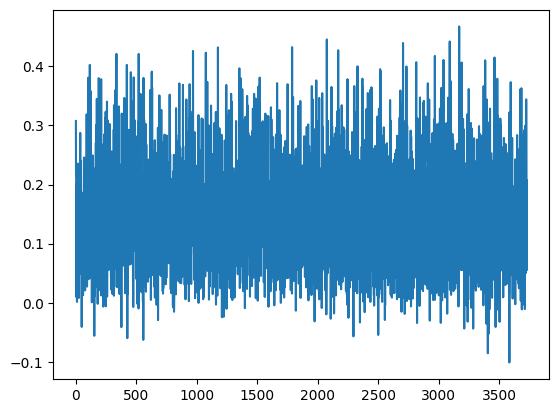

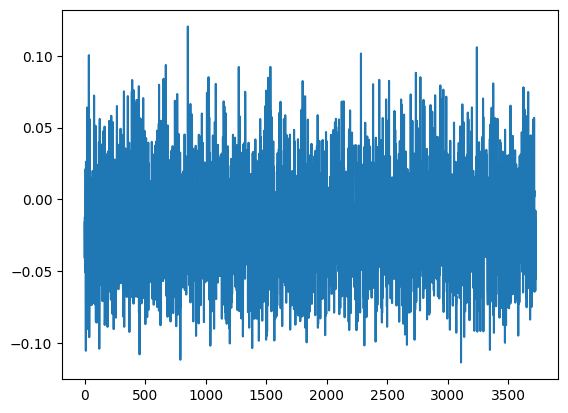

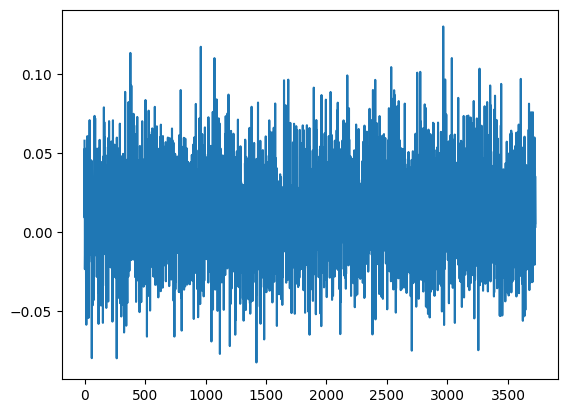

In [4]:
import matplotlib.pyplot  as plt
plt.plot(fuse_text_sim)
plt.show()
plt.plot(fuse_audio_sim)
plt.show()
plt.plot(audio_text_sim)
plt.show()